# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
from __future__ import division
from functools import reduce

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


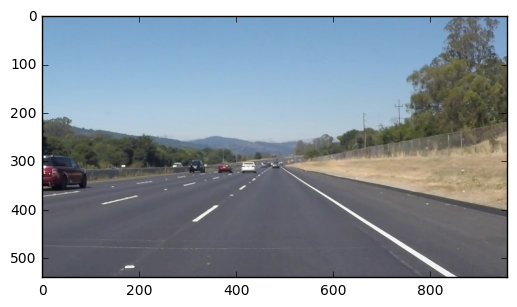

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# my own helper function

def draw_poly_vertices_as_lines(img, vertices, color):
    masked_test_print_color = (0, 255, 0)
    cv2.line(image, (vertices[0][0][0], vertices[0][0][1]), (vertices[0][1][0], vertices[0][1][1]), masked_test_print_color, 10)
    cv2.line(image, (vertices[0][1][0], vertices[0][1][1]), (vertices[0][2][0], vertices[0][2][1]), masked_test_print_color, 10)
    cv2.line(image, (vertices[0][2][0], vertices[0][2][1]), (vertices[0][3][0], vertices[0][3][1]), masked_test_print_color, 10)
    cv2.line(image, (vertices[0][0][0], vertices[0][0][1]), (vertices[0][3][0], vertices[0][3][1]), masked_test_print_color, 10)
    return cv2.addWeighted(image, 0.8, img, 1, 0)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

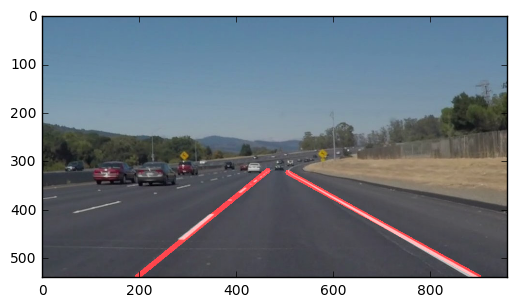

In [14]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# start with solidWhiteCurve.jpg

# reading in an image
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#image = mpimg.imread('test_images/solidYellowCurve.jpg')
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#image = mpimg.imread('test_images/solidYellowLeft.jpg')
#image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
gray = grayscale(image)

# define kernel size
kernel_size = 7
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

# apply Canny
low_threshold = 50 #50
high_threshold = 150 #150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# polygon mask
mask = np.zeros_like(edges)
ignore_mask_color = 255

imshape = image.shape
# vertices = np.array([[(0, imshape[0]), (450, 290), (490, 290), (imshape[1], imshape[0])]], dtype = np.int32)
vertices = np.array([[(0, imshape[0]), (450, 315), (490, 315), (imshape[1], imshape[0])]], dtype = np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)
#linesMasked = draw_poly_vertices_as_lines(image, vertices, (0, 255, 0))
#plt.imshow(linesMasked)


# Hough Transform
rho = 2
theta = np.pi/180
threshold = 20 #20
min_line_length = 5
max_line_gap = 20 #20
line_image = np.copy(image)*0

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

leftM = 0
rightM = 0
findSample = 0 # find flag
slopeDifference = 0.2
for line in lines:
    for x1, y1, x2, y2 in line:
        for newline in lines:
            for a1, b1, a2, b2 in newline:
                if x1 == a1 and y1 == b1 and x2 == a2 and y2 == b2: 
                    # all the same, ignore
                    continue
                m1 = ((y2-y1)/(x2-x1))
                m2 = ((b2-b1)/(a2-a1))
                if m1 > 0 and m2 < 0:
                    leftM = m1
                    rightM = m2
                    #print("leftM = %f, rightM = %f" %(leftM, rightM))
                    findSample = 1
                if m1 < 0 and m2 > 0:
                    leftM = m2
                    rightM = m1
                    #print("leftM = %f, rightM = %f" %(leftM, rightM))
                    findSample = 1
                else:
                    continue
                if findSample == 1: break
            if findSample == 1: break
        if findSample == 1: break
    if findSample == 1: break

leftLinePoints = []
rightLinePoints = []
for line in lines:
    for x1, y1, x2, y2 in line:
        m = ((y2-y1)/(x2-x1))

        if abs(m - rightM) <= slopeDifference:
            #right line points
            rightLinePoints.append((x1, y1))
            rightLinePoints.append((x2, y2))
        elif abs(m - leftM) <= slopeDifference:
            #left line points
            leftLinePoints.append((x1, y1))
            leftLinePoints.append((x2, y2))
        else:
            continue

# find smallest points in left
# get array of y points for leftPoints
leftYPoints = list(map(lambda x: x[1], leftLinePoints))
minLeftYPoints = min(leftYPoints)
maxLeftYPoints = max(leftYPoints)

minLeftPoints = list(filter(lambda x: x[1] == minLeftYPoints, leftLinePoints))[0]
maxLeftPoints = list(filter(lambda x: x[1] == maxLeftYPoints, leftLinePoints))[0]

# get array of y points for rightPoints
rightYPoints = list(map(lambda x: x[1], rightLinePoints))
minRightYPoints = min(rightYPoints)
maxRightYPoints = max(rightYPoints)

minRightPoints = list(filter(lambda x: x[1] == minRightYPoints, rightLinePoints))[0]
maxRightPoints = list(filter(lambda x: x[1] == maxRightYPoints, rightLinePoints))[0]

# calculate final slope
final_left_m = (maxLeftPoints[1] - minLeftPoints[1]) / (maxLeftPoints[0] - minLeftPoints[0])
final_left_b = (minLeftPoints[1] - (final_left_m * minLeftPoints[0]))
final_right_m = (maxRightPoints[1] - minRightPoints[1]) / (maxRightPoints[0] - minRightPoints[0])
final_right_b = (minRightPoints[1] - (final_right_m * minRightPoints[0]))

height, width, channels = image.shape
final_left_point = (height - final_left_b) / final_left_m
final_right_point = (height - final_right_b) / final_right_m

# draw lines
line_color = (255, 0, 0)
cv2.line(line_image, minLeftPoints, (int(final_left_point), height), line_color, 10)
cv2.line(line_image, minRightPoints, (int(final_right_point), height), line_color, 10)

# create color binary image
color_edges = np.dstack((edges, edges, edges))

#lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)

# print
# print('This image is:', type(blur_gray), 'with dimesions:', blur_gray.shape)
plt.imshow(lines_edges)


# Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # reading in an image
    # image = mpimg.imread('test_images/solidWhiteRight.jpg')
    #image = mpimg.imread('test_images/solidWhiteCurve.jpg')
    #image = mpimg.imread('test_images/solidYellowCurve.jpg')
    #image = mpimg.imread('test_images/solidYellowCurve2.jpg')
    #image = mpimg.imread('test_images/solidYellowLeft.jpg')
    #image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
    gray = grayscale(image)

    kernel_size = 7
    blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

    # apply Canny
    low_threshold = 50 #50
    high_threshold = 150 #150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # polygon mask
    mask = np.zeros_like(edges)
    ignore_mask_color = 255

    imshape = image.shape
    # vertices = np.array([[(0, imshape[0]), (450, 290), (490, 290), (imshape[1], imshape[0])]], dtype = np.int32)
    vertices = np.array([[(0, imshape[0]), (450, 315), (490, 315), (imshape[1], imshape[0])]], dtype = np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    #linesMasked = draw_poly_vertices_as_lines(image, vertices, (0, 255, 0))
    #plt.imshow(linesMasked)


    # Hough Transform
    rho = 2
    theta = np.pi/180
    threshold = 20 #20
    min_line_length = 5
    max_line_gap = 20 #20
    line_image = np.copy(image)*0

    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

    leftM = 0
    rightM = 0
    findSample = 0 # find flag
    slopeDifference = 0.2
    for line in lines:
        for x1, y1, x2, y2 in line:
            for newline in lines:
                for a1, b1, a2, b2 in newline:
                    if x1 == a1 and y1 == b1 and x2 == a2 and y2 == b2: 
                        # all the same, ignore
                        continue
                    m1 = ((y2-y1)/(x2-x1))
                    m2 = ((b2-b1)/(a2-a1))
                    if m1 > 0 and m2 < 0:
                        leftM = m1
                        rightM = m2
                        #print("leftM = %f, rightM = %f" %(leftM, rightM))
                        findSample = 1
                    if m1 < 0 and m2 > 0:
                        leftM = m2
                        rightM = m1
                        #print("leftM = %f, rightM = %f" %(leftM, rightM))
                        findSample = 1
                    else:
                        continue
                    if findSample == 1: break
                if findSample == 1: break
            if findSample == 1: break
        if findSample == 1: break

    leftLinePoints = []
    rightLinePoints = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = ((y2-y1)/(x2-x1))

            if abs(m - rightM) <= slopeDifference:
                #right line points
                rightLinePoints.append((x1, y1))
                rightLinePoints.append((x2, y2))
            elif abs(m - leftM) <= slopeDifference:
                #left line points
                leftLinePoints.append((x1, y1))
                leftLinePoints.append((x2, y2))
            else:
                continue

    # find smallest points in left
    # get array of y points for leftPoints
    leftYPoints = list(map(lambda x: x[1], leftLinePoints))
    minLeftYPoints = min(leftYPoints)
    maxLeftYPoints = max(leftYPoints)

    minLeftPoints = list(filter(lambda x: x[1] == minLeftYPoints, leftLinePoints))[0]
    maxLeftPoints = list(filter(lambda x: x[1] == maxLeftYPoints, leftLinePoints))[0]

    # get array of y points for rightPoints
    rightYPoints = list(map(lambda x: x[1], rightLinePoints))
    minRightYPoints = min(rightYPoints)
    maxRightYPoints = max(rightYPoints)

    minRightPoints = list(filter(lambda x: x[1] == minRightYPoints, rightLinePoints))[0]
    maxRightPoints = list(filter(lambda x: x[1] == maxRightYPoints, rightLinePoints))[0]

    # calculate final slope
    final_left_m = (maxLeftPoints[1] - minLeftPoints[1]) / (maxLeftPoints[0] - minLeftPoints[0])
    final_left_b = (minLeftPoints[1] - (final_left_m * minLeftPoints[0]))
    final_right_m = (maxRightPoints[1] - minRightPoints[1]) / (maxRightPoints[0] - minRightPoints[0])
    final_right_b = (minRightPoints[1] - (final_right_m * minRightPoints[0]))

    height, width, channels = image.shape
    final_left_point = (height - final_left_b) / final_left_m
    final_right_point = (height - final_right_b) / final_right_m

    # draw lines
    line_color = (255, 0, 0)
    cv2.line(line_image, minLeftPoints, (int(final_left_point), height), line_color, 10)
    cv2.line(line_image, minRightPoints, (int(final_right_point), height), line_color, 10)

    # create color binary image
    color_edges = np.dstack((edges, edges, edges))

    #lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)
    # print
    # print('This image is:', type(blur_gray), 'with dimesions:', blur_gray.shape)
    # plt.imshow(lines_edges)

    return lines_edges

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:07<00:00, 30.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.09 s, sys: 414 ms, total: 4.5 s
Wall time: 8.18 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:24<00:00, 28.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 13.1 s, sys: 1.23 s, total: 14.3 s
Wall time: 25.2 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Detect Lane Lines On Video (project)
  Process on video is similar to process on still images. What we  djkdo is to
  consider write a pipeline process on still images and treat the video as a
  list of images and apply the pipe line on it. We already have learned how to
  detect lane lines on a still image. Here is the difficult part to what we
  learned. Previously we use ~hough transform~ to detect lines, now we need to
  only draw on solid line for left and right lane. that solid line should be
  connect to the bottom edge so we can detect where the lane starts while
  driving.

### Pipeline on Still Image
   For detail on how to detect lines, please see ~Canny Edge Detection~ and
   ~Hough Transform~. Previously, we print lines on map using the following
   method.
  
   #+BEGIN_SRC python
     for line in lines:
         for x1,y1,x2,y2 in line:
             cv2.line(img, (x1, y1), (x2, y2), color, thickness)
   #+END_SRC 

   That method draws all the lines we can find, but now we want only two lines.
   One on the left and one on the right. How am I going to tweak this method and
   make it draw two lines left and right?

   Here is how I did. It must not be the best plan but it is the one I use in
   the project. First, we can see that the slope for left line is negative and
   the slope for the right line is positive. (When x increase and y increase,
   the slope is positive).

   So I loop all the lines and find one with positive slope and one with
   negative slope.

   Now here are two ways I can do. One is to just loop though all the lines and
   find all the slopes, make an array of left slops and right slops put the
   positive and negative number into the correct array, and calculate left and
   right slope average. But this is not what I did. Why?

   When I calculate the slope, I found out that some line I detected does not
   belongs to left or right, so when I get one sample of left and right slope I
   calculate if the slope is 0.1 difference to the left or right slope. If this
   close to neither left nor right, I ignore this line. The rest the similar, I
   put slope of the line I want in to left array and right array, calculate the
   average.

   Note: when I was looping though the lines and calculate the slope, I also
   need to calculate the y-intersection points. See formula below to get all the
   y-intersections for the line and also calculate the average.

   #+BEGIN_LaTeX
   m = (y_2 - y_1) / (x_2 - x_1)
   b = y - m * x
   #+END_LaTeX 

   From this point, I have both slope and y-interactions for left line and right
   line. There is one more thing we need to do. The line we draw must starts at
   the bottom edge of the image. However, the min points we get may not 100%
   starting from the edge, so we need to calculate the point value ourselves.
   How? $y = mx + b$, we have ~m~ and we have ~b~, the y is the image height, so
   we can get x. 

   The other point will the point with the minY value. filter all the points for
   both left line and right line and find the minimum y-value point.
  

### Improvement
  How to make the algorithm more robust? Currently the algorithm only detect
  straight line because I am using the linear equation. So in situation when the
  road is not straight, this algorithm may fail. In order to make it better,
  instead calculating and drawing the straight line, we can draw the curve. I
  think drawing curve is not that as easy as drawing the line so another work
  round may be calculating multiple slope and drawing many lines to form a
  curve.

  Above are just my thoughts on how to make improvements.




## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:20<00:00, 12.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 10.4 s, sys: 1.6 s, total: 12 s
Wall time: 22.2 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))